## 本筆記將建立DenseNet模型。我們練習的資料集為CIFAR10。


#### 核心概念: 

* 以```subclassing API```來構築模型。
* 學會建構和訓練DenseNet。

---

CIFAR10資料集：https://www.cs.toronto.edu/~kriz/cifar.html

---

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KERAS_BACKEND"] = "torch"

import keras

keras.config.backend()

'torch'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
import pandas as pd

from sklearn.metrics import classification_report
import json
import pickle

## <a id='01'>載入圖片至電腦記憶體 </a>

data_batch_1, data_batch_2,..data_batch_5以及test_batch是以binary的方式儲存在硬碟裡。以下我們寫幾個函數，用以載入這些binary格式的圖檔至電腦內的記憶體中，並且將圖的以矩陣的方式儲存。這些圖矩陣的shape為(Number of figures,Width,Height,Channel)。

In [4]:
def load_batch(fpath):
    """This function extract a batch of CIFAR10 data
    from the chosen binary file.
    This function is a simplified version of
    https://github.com/keras-team/keras/blob/master/keras/datasets/cifar.py
    """
    with open(fpath, "rb") as f:
        d = pickle.load(f, encoding="bytes")
        # Keys are in the "byte" format. Let's decode them into utf8 strings.
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode("utf8")] = v
        d = d_decoded
    data = d["data"]
    labels = d["labels"]
    data = data.reshape(data.shape[0], 3, 32, 32)
    data = data.transpose(0, 2, 3, 1)
    return data, labels


def load_data(path):
    """
    載入以binary方式儲存的影像至電腦內記憶體。
    """
    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 32, 32, 3), dtype="uint8")
    y_train = np.zeros((num_train_samples,), dtype="uint8")

    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_") + str(i)
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000 : i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000 : i * 10000] = labels

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    return (x_train, y_train), (np.array(x_test), np.array(y_test, dtype="uint8"))

In [5]:
(x_train, y_train), (x_test, y_test) = load_data("./cifar-10-batches-py")

In [6]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


以上，我們得到了x_train, x_test, y_train,y_test四個放置圖片的矩陣，其shape均為(Number of figures,Width,Height,Channel)。

接著，我們抽出幾張圖來看，稍微了解一下這些資料大概的樣貌：

In [7]:
with open("./cifar-10-batches-py/labels.txt") as reader:
    fig_labels = reader.read()
fig_labels = fig_labels.split("\n")[:-1]

In [8]:
idx_to_label = {}
for idx, fig_labels in enumerate(fig_labels):
    idx_to_label[idx] = fig_labels

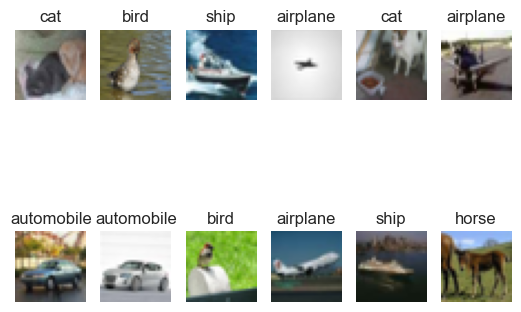

In [9]:
# 隨機抽取12張圖來看一下
num_figures_display = 12
fig_indexes = np.random.choice(x_train.shape[0], num_figures_display)

fig, axes = plt.subplots(2, 6)
for fig_idx, axis in zip(fig_indexes, axes.reshape(-1)):
    axis.axis("off")
    axis.imshow(x_train[fig_idx])
    axis.set_title(idx_to_label[y_train[fig_idx]])

## <a id='02'> 將圖片做resize以及normalization </a>

In [10]:
import cv2
from keras.utils import to_categorical

# 做normalization。
# 一個簡單的方式，是將x直接除以255，使得x內的所有值均分佈於[0,1]之間。
x_train = x_train / 255.0
x_test = x_test / 255.0

# 調整x_train每張圖的大小從(32,32)乘以三倍，變成(96,96)。
x_train_resized = np.zeros((50000, 96, 96, 3), dtype=np.float32)
for idx, img in enumerate(x_train):
    if idx % 10000 == 0:
        print(idx)
    x_train_resized[idx, :] = cv2.resize(
        img, None, fx=3, fy=3, interpolation=cv2.INTER_AREA
    )

# 調整x_test每張圖的大小從(32,32)乘以三倍，變成(96,96)。
x_test_resized = np.zeros((10000, 96, 96, 3), dtype=np.float32)
for idx, img in enumerate(x_test):
    if idx % 1000 == 0:
        print(idx)
    x_test_resized[idx, :] = cv2.resize(
        img, None, fx=3, fy=3, interpolation=cv2.INTER_AREA
    )

# 將y轉換成為one hot的形式
y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)

0
10000
20000
30000
40000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


---

## <a id='05'> 微調```residual block```成為```dense block```，並建立出DenseNet </a>

In [11]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KERAS_BACKEND"] = "torch"

from keras import layers, models, regularizers
from keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, min_lr=1e-20, verbose=1
)

keras.config.backend()

'torch'

In [21]:
class ConvBlock(keras.layers.Layer):
    def __init__(self, filters, kernel_size=3, strides=1, use_bias=True, epsilon=1e-3, axis=-1, l2_strength=1e-4, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)

        # if axis == -1 or axis == 3:
        #     data_format = "channels_last"
        # elif axis == 1 or axis == -3:
        #     data_format = "channels_firt"
        # else:
        #     raise ValueError("Data format invalid.")

        self.bottleneck = keras.layers.Conv2D(
            filters // 2,  
            kernel_size=(1, 1),
            strides=1,
            use_bias=False,
            kernel_regularizer=keras.regularizers.l2(l2_strength),
            padding="same",
        )

        self.conv = keras.layers.Conv2D(
            filters,
            kernel_size=kernel_size,
            strides=strides,
            use_bias=use_bias,
            kernel_regularizer=keras.regularizers.l2(l2_strength),  
            padding="same",
        )

        norm_params = {"epsilon": epsilon, "axis": axis}
        self.bn = keras.layers.BatchNormalization(**norm_params)
        self.activation = keras.layers.PReLU()

    def call(self, x, training=None):
        x = self.bottleneck(x)
        x = self.conv(x)
        x = self.bn(x, training=training)
        return self.activation(x)


class DenseBlock(keras.layers.Layer):
    def __init__(
        self, filters, growth_rate=None, downsample=False, strides=1, use_bias=True, epsilon=1e-3, axis=-1, l2_strength=1e-5, **kwargs):
        super(DenseBlock, self).__init__(**kwargs)

        # if axis == -1 or axis == 3:
        #     data_format = "channels_last"
        # elif axis == 1 or axis == -3:
        #     data_format = "channels_first"
        # else:
        #     raise ValueError("Data format invalid.")
        
        if growth_rate is None:
            growth_rate = int(filters // 1.5)

        self.bottleneck = keras.layers.Conv2D(
            growth_rate,
            kernel_size=(1, 1),
            strides=1,
            use_bias=False,
            kernel_regularizer=keras.regularizers.l2(l2_strength),
            padding="same",
        )

        
        self.conv1 = keras.layers.Conv2D(
            growth_rate,
            kernel_size=3,
            strides=strides,
            use_bias=use_bias,            
            kernel_regularizer=keras.regularizers.l2(l2_strength),
            padding="same",
        )
              
        self.dropout = layers.Dropout(0.2)

        self.match_channels = keras.layers.Conv2D(
            filters,            
            kernel_size=(1, 1),  
            strides=1,
            use_bias=False,            
            kernel_regularizer=keras.regularizers.l2(l2_strength),
            padding="same",
        )

        self.downsample = downsample
        if self.downsample:
            self.pool = layers.AveragePooling2D((2, 2), strides=2, padding="same")            

        norm_params = {"epsilon": epsilon, "axis": axis}
        self.norm1 = keras.layers.BatchNormalization(**norm_params)
        self.norm2 = keras.layers.BatchNormalization(**norm_params)
        # self.norm3 = keras.layers.BatchNormalization(**norm_params)

    def call(self, x, training=None):
        x1 = self.norm1(x, training=training)
        x1 = keras.activations.relu(x1)
        x1 = self.bottleneck(x1)  
        x1 = self.conv1(x1)
        x1 = self.norm2(x1, training=training)
        x1 = keras.activations.relu(x1)
        x1 = self.dropout(x1, training=training)

        if self.downsample:
            x = self.pool(x) 
            x1 = self.pool(x1)

        x = self.match_channels(x) 
        return layers.Concatenate()([x, x1]) 

# 建立模型
model = models.Sequential()
model.add(ConvBlock(filters=64, input_shape=(32, 32, 3)))
model.add(ConvBlock(filters=64))
model.add(DenseBlock(filters=64))
model.add(layers.Conv2D(64, (1, 1), padding="same", activation="relu"))
model.add(layers.AveragePooling2D((2, 2), strides=2, padding="same"))
model.add(DenseBlock(filters=128))
model.add(layers.Conv2D(128, (1, 1), padding="same", activation="relu"))
model.add(layers.AveragePooling2D((2, 2), strides=2, padding="same"))
model.add(DenseBlock(filters=128))  
model.add(DenseBlock(filters=128))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation="softmax"))

# 檢視模型摘要
model.summary()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_13008\1621900599.py:3: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(ConvBlock, self).__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_block_6 (ConvBlock)        │ (None, 32, 32, 64)     │        84,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_7 (ConvBlock)        │ (None, 32, 32, 64)     │        86,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_12 (DenseBlock)     │ (None, 32, 32, 106)    │        23,126 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 32, 32, 64)     │         6,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 16, 16, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_13 (DenseBlock)     │ (None, 16, 16, 213)    │        79,338 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 16, 16, 128)    │        27,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_7             │ (None, 8, 8, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_14 (DenseBlock)     │ (None, 8, 8, 213)      │        93,226 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_15 (DenseBlock)     │ (None, 8, 8, 213)      │       111,671 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 213)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        27,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 548,619 (2.09 MB)

 Trainable params: 546,831 (2.09 MB)

 Non-trainable params: 1,788 (6.98 KB)

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.3127 - loss: 1.8790 - val_accuracy: 0.2809 - val_loss: 2.2616 - learning_rate: 5.0000e-04
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.5672 - loss: 1.2596 - val_accuracy: 0.5880 - val_loss: 1.2088 - learning_rate: 5.0000e-04
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.6447 - loss: 1.0413 - val_accuracy: 0.6259 - val_loss: 1.1790 - learning_rate: 5.0000e-04
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.6983 - loss: 0.9043 - val_accuracy: 0.6637 - val_loss: 1.0033 - learning_rate: 5.0000e-04
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.7381 - loss: 0.8044 - val_accuracy: 0.5977 - val_loss: 1.1592 - learning_rate: 5.0000e-04
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.7622 - loss: 0.7349 - val_accuracy: 0.6760 - val_loss: 0.9424 - learning_rate: 5.0000e-04
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/ste

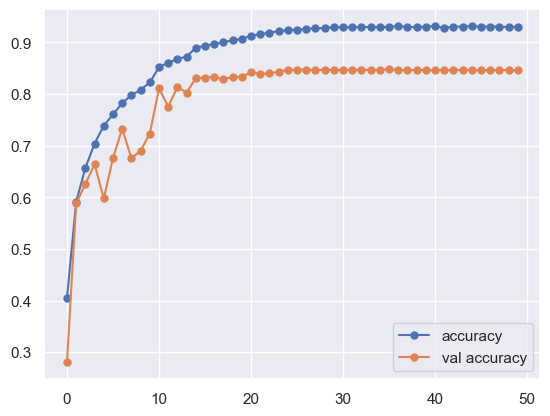

In [22]:
# 訓練模型

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-10, verbose=1
)
optimizer = keras.optimizers.AdamW(learning_rate=5e-4, weight_decay=1e-4)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


history = model.fit(
    x=x_train,
    y=y_train_one_hot,
    validation_data=(x_test, y_test_one_hot),
    epochs=50,
    batch_size=128,
    callbacks=[lr_scheduler],
)

# 畫出訓練過程
plt.plot(history.history["accuracy"], ms=5, marker="o", label="accuracy")
plt.plot(history.history["val_accuracy"], ms=5, marker="o", label="val accuracy")
plt.legend()
plt.show()

# 模型訓練與調整記錄

## 1. 初始模型架構
希望使用 **DenseNet** 架構進行影像分類，目標是讓 **accuracy** 和 **val_accuracy** 穩定達到 80% 以上。  

### **初始模型結構**
- **ConvBlock** (32 filters, `MaxPooling2D`)
- **DenseBlock** (32 filters, growth rate 16, `Concatenate()`)
- **4 層 DenseBlock**
- **Flatten() + Dense(10)**
- **Adam Optimizer，learning rate `3e-4`**
- **Epochs: 15, Batch size: 128**
- **ReduceLROnPlateau** 進行學習率調整

### **初始訓練結果**
- `accuracy`: 約 **79%**
- `val_accuracy`: 約 **66%**
- `val_loss` 偏高，模型出現 **overfitting** 問題。

---

## 2. 優化歷程

### **(1) 針對overfitting問題進行調整**
#### **調整L2 Regularization**
- 初始 `l2_strength=1e-5`，調整至 **`1e-3`**
- 在 **DenseBlock** 內新增 `Dropout(0.3)`，減少overfitting

#### **調整 DenseBlock 結構**
- 由 **Concatenate()** 改為 **Add()**
- 使用 **1x1 Conv** (`Conv2D(filters, kernel_size=(1, 1)`) 來確保輸出維度正確

#### **加入learning rate動態調整機制**
- `ReduceLROnPlateau` 調整：
  - `monitor="val_loss", factor=0.5, patience=2, min_lr=1e-20`
  - 讓learning rate能在驗證集 loss 不下降時自動降低

### **(2) 進一步調整模型結構**
#### **新增與調整convolution layer**
- **增加** ConvBlock **層數**
- **調整 filter 大小**：
  - `filters=32` → `filters=64`
  - `growth_rate=filters // 2` → `growth_rate=filters // 3`
  - `DenseBlock(filters=32) → DenseBlock(filters=64)`

#### **更改pooling layer策略**
- **新增** `AveragePooling2D()`，使模型能更有效壓縮特徵
- 在部分 DenseBlock 之後加上 **GlobalAveragePooling2D()**，取代 `Flatten()`

#### **嘗試不同的optimizer**
- **Adam → AdamW**（降低 L2 正則化影響）
- 初始learning rate調整為 **`5e-4`**

---

## 3. 最終模型架構
```python
model = models.Sequential()
model.add(ConvBlock(filters=64, input_shape=(32, 32, 3)))
model.add(ConvBlock(filters=64))
model.add(DenseBlock(filters=64))
model.add(layers.Conv2D(64, (1, 1), padding="same", activation="relu"))
model.add(layers.AveragePooling2D((2, 2), strides=2, padding="same"))
model.add(DenseBlock(filters=128))
model.add(layers.Conv2D(128, (1, 1), padding="same", activation="relu"))
model.add(layers.AveragePooling2D((2, 2), strides=2, padding="same"))
model.add(DenseBlock(filters=128))  
model.add(DenseBlock(filters=128))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation="softmax"))
```

---

## 4. 最終訓練參數

```python
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-10, verbose=1
)

optimizer = keras.optimizers.AdamW(learning_rate=5e-4)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model.fit(
    x=x_train,
    y=y_train_one_hot,
    validation_data=(x_test, y_test_one_hot),
    epochs=50,
    batch_size=128,
    callbacks=[lr_scheduler],
)
```

---

## 5. 訓練結果與分析

### **最終訓練成果**
| Epoch | Training Accuracy | Validation Accuracy | Validation Loss |
|--------|------------------|--------------------|----------------|
| 26 | 93% | 84.5% | 0.573 |

### **分析**
#### **overfitting問題改善**
- `val_accuracy` **從 66% 提升至 84.5%**，且 **val_loss 下降至 0.573**。
- 透過 **L2 Regularization (`ConvBlock: 1e-4, DenseBlock: 1e-5`)、Dropout(0.3) 及 Batch Size 調整**，成功減少 overfitting。

#### **驗證集準確度穩定**
- `val_accuracy` **在 epoch 42 後穩定**，沒有明顯的下降，顯示模型已達收斂狀態。
- `Training Accuracy` 和 `Validation Accuracy` 間的差距較小，模型具備良好泛化能力。

#### **未來可進一步優化的方向**
- **嘗試 Data Augmentation**（目前未加入）來增加資料變異性，提升泛化能力。
- **擴展 Batch Size 至 512 或 1024**，觀察是否能進一步提升 `val_accuracy`。
- **調整 growth_rate**，避免 DenseBlock 內部維度過大導致計算資源消耗過多。
- **嘗試 Bottleneck 設計 (`1x1 Conv → 3x3 Conv → 1x1 Conv`)** 來提高 DenseBlock 計算效率。

---

## 6. 結論

###  **最終模型達到 84.5% val_accuracy**
- 在不overfitting的前提下，**準確度穩定在 84.5%**， `val_loss` 下降至 **0.573**。
- 透過 **調整模型結構、加入 L2 Regularization、改進pooling layer策略、optimizer AdamW**，顯著提升val_accuracy。

###  **後續可進行的改善**
#### **加入 Data Augmentation**
- **目標**：透過影像增強技術（隨機翻轉、裁切、顏色變化）讓模型更具泛化能力。
- **方法**：
  ```python
  data_augmentation = keras.Sequential([
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.1),
      layers.RandomContrast(0.1),
  ])
  ```

####  **調整 growth_rate**
- **目標**：降低 `DenseBlock` 內部維度過大導致計算量上升，影響收斂速度。
- **方法**：
  ```python
  growth_rate = int(filters // 2)  # 從 filters // 3 調整至 filters // 2
  ```

####  **測試不同 Batch Size**
- **目標**：觀察不同 Batch Size（`512` 或 `1024`）對 `loss` 及 `accuracy` 的影響。
- **預測效果**：
  - **512**：可能可以提高穩定性，但避免過度平均梯度。
  - **1024**：可能會降低 `loss`，但如果過大可能導致學習不足。

---

####  **嘗試 CutMix 或 MixUp 技術**
- **目標**：進一步強化模型的學習能力，提升 `val_accuracy` 穩定性。
- **CutMix 技術**：
  - 透過**部分遮擋圖像**，讓模型學習到更具挑戰性的樣本。
- **MixUp 技術**：
  - 透過**混合兩張不同的圖像**，增加學習變異性。

---

###  **結論**
- 目前的模型表現**尚可**，可視需求再進行優化。 
- **最終訓練結果**：
  - **Training Accuracy** ≈ `93%`
  - **Validation Accuracy** ≈ `84.5%`
  - **Validation Loss** ≈ `0.573`
  - **Epoch** ≈ `26` 開始穩定

- **關於其他資訊**：
  - **DenseNet-121** : 有查到相關資訊，使用 `DenseNet-121` 有機會提升 `val_accuracy` 至93-95%，未來會繼續嚐試看看。
  
 **此模型可作為基礎版本，未來可以嘗試不同增強技術來提升泛化能力。** 

